In [33]:
### allows to direct changes in the packages to be immidiately visibe in the notebook 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
import os, sys
sys.path.append(os.getcwd() + '/../..')
sys.path.append(os.getcwd() + '/..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from datetime import datetime
import helper_v1 as helper

from matplotlib import pyplot as plt 

from merf.merf import MERF
from sklearn.model_selection import cross_val_score, train_test_split

import skopt
from skopt.space import Real, Integer, Categorical
import itertools
from skopt import gp_minimize
import gc

In [37]:
df_data = pd.read_csv('./data/cell/traffic_cells.csv', sep='|', encoding="UTF-8",
                    warn_bad_lines=False, error_bad_lines=False, header=0, index_col=0)

C:\ProgramData\Anaconda3\envs\shared\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [38]:
df_data.head()

,cell_key,ds,prb_dl_used_avg,thrp_dl_mb
1057716,0,2019-01-02 00:00:00,15.076,853.171461
1049620,0,2019-01-02 00:15:00,17.461,993.111915
725344,0,2019-01-02 00:30:00,9.163,266.322692
1072162,0,2019-01-02 00:45:00,12.535,318.778401
1078715,0,2019-01-02 01:00:00,13.531,393.152370


#### We have 81 unique cells logging the data

In [39]:
df_data.cell_key.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80], dtype=int64)

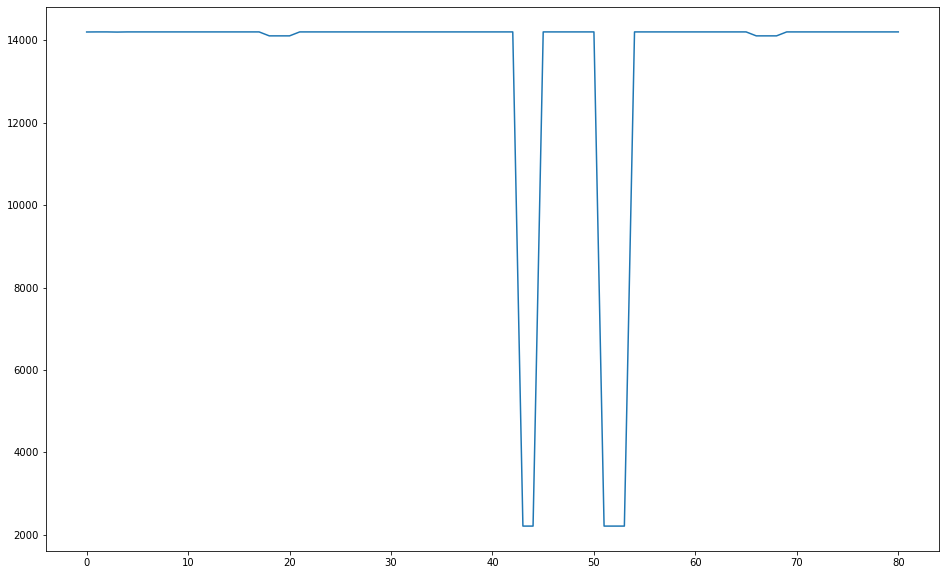

In [40]:
fig = plt.figure(figsize=(16,10))
plt.plot(df_data.groupby(['cell_key'])['ds'].count())

#### Five cells have data for fewer days

In [41]:
df_data.groupby(['cell_key'])['ds'].count().sort_values()[0:20]

cell_key
44     2208
51     2208
52     2208
53     2208
43     2208
20    14112
19    14112
18    14112
66    14112
67    14112
68    14112
3     14204
0     14206
70    14208
78    14208
45    14208
46    14208
47    14208
48    14208
49    14208
Name: ds, dtype: int64

#### Lets see how it looks for one cell

In [9]:
one_cell_only = df_data[df_data.cell_key==0]

INFO     [category.py:218] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO     [category.py:218] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


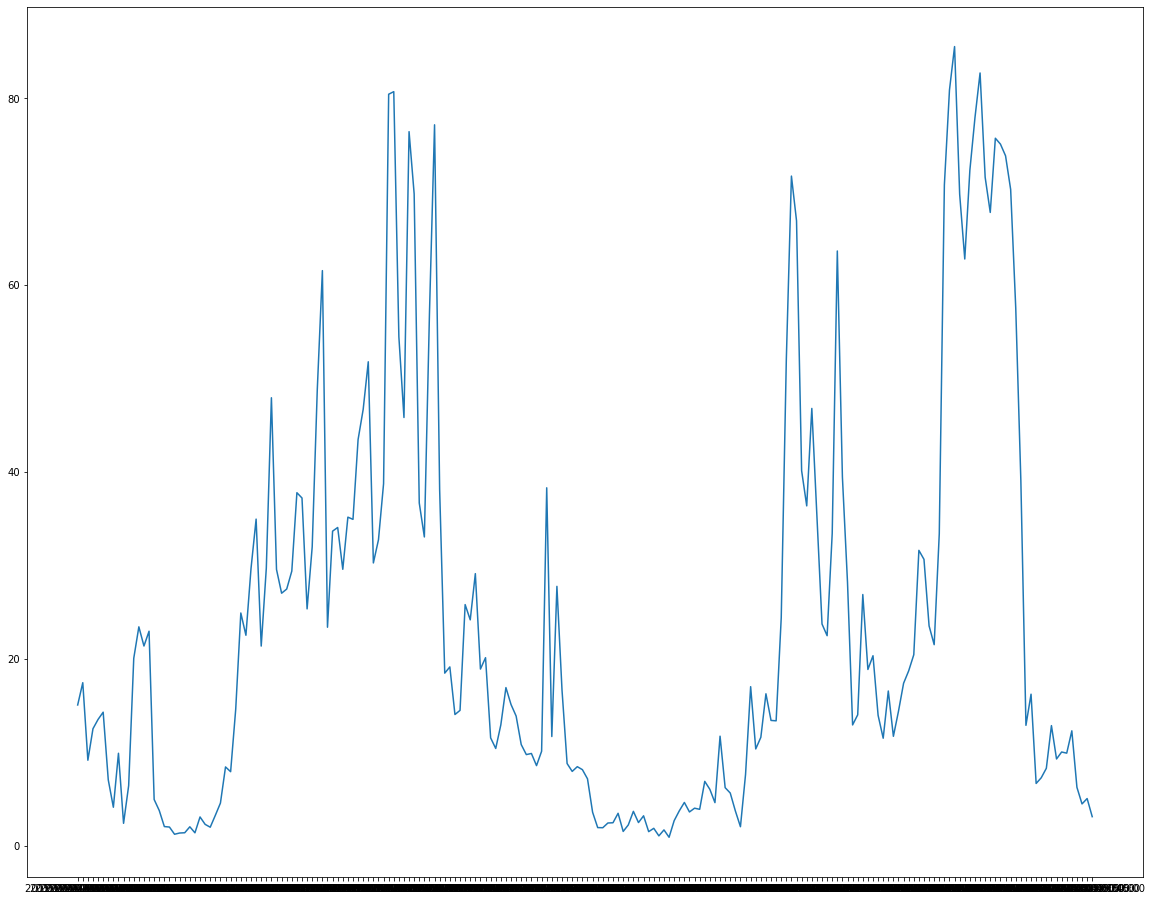

In [10]:
fig = plt.figure(figsize=(20,16))
plt.plot(one_cell_only.ds[0:200], one_cell_only.y[0:200])

## Lets prepare the data and add additional fields/information/columns

#### Day of a Week gives importatn insight here since traffic on weekends are higher compared to normal week days therefore, we explicitly specify day of week 

In [42]:
df_data['week_days'] = df_data['ds'].apply(helper.is_weekend)
df_data['week_ends'] = ~df_data['ds'].apply(helper.is_weekend)

In [43]:
df_data

,cell_key,ds,prb_dl_used_avg,thrp_dl_mb,week_days,week_ends
1057716,0,2019-01-02 00:00:00,15.076,853.171461,True,False
1049620,0,2019-01-02 00:15:00,17.461,993.111915,True,False
725344,0,2019-01-02 00:30:00,9.163,266.322692,True,False
1072162,0,2019-01-02 00:45:00,12.535,318.778401,True,False
1078715,0,2019-01-02 01:00:00,13.531,393.152370,True,False
...,...,...,...,...,...,...
170217,80,2019-06-01 22:45:00,7.253,271.236440,False,True
174118,80,2019-06-01 23:00:00,7.670,346.389835,False,True
172113,80,2019-06-01 23:15:00,4.547,186.617697,False,True
174119,80,2019-06-01 23:30:00,3.470,115.398926,False,True


#### Traffic patterns are also different on holidays compared to normal working days therefore, the holiday data is also added

In [44]:
df_holidays = helper.get_national_holidays(year=2019)
df_holidays

,holiday,ds,lower_window,upper_window
0,New year,2019-01-01,0,1
1,Epiphany,2019-01-06,0,1
2,Easter Monday,2019-04-22,0,1
3,State Holiday,2019-05-01,0,1
4,Ascension Thursday,2019-05-30,0,1
5,Whit Monday,2019-06-10,0,1
6,Corpus Christi,2019-06-20,0,1
7,Assumption of Mary to Heaven,2019-08-15,0,1
8,National Holiday,2019-10-26,0,1
9,All Saints Day,2019-11-01,0,1


#### Depending upon what series is going on, the network traffic varies alot as well, so it is usefull to add this info. as well, there are many free sites from where such data can be donwloaded

In [45]:
match_dates = helper.get_matchdates()
conditions = df_data.ds.isin(match_dates.DateTimeAdj)

In [46]:
df_data['game_played'] = np.select(conditions, df_data.ds)

In [47]:
df_data

,cell_key,ds,prb_dl_used_avg,thrp_dl_mb,week_days,week_ends,game_played
1057716,0,2019-01-02 00:00:00,15.076,853.171461,True,False,0
1049620,0,2019-01-02 00:15:00,17.461,993.111915,True,False,0
725344,0,2019-01-02 00:30:00,9.163,266.322692,True,False,0
1072162,0,2019-01-02 00:45:00,12.535,318.778401,True,False,0
1078715,0,2019-01-02 01:00:00,13.531,393.152370,True,False,0
...,...,...,...,...,...,...,...
170217,80,2019-06-01 22:45:00,7.253,271.236440,False,True,0
174118,80,2019-06-01 23:00:00,7.670,346.389835,False,True,0
172113,80,2019-06-01 23:15:00,4.547,186.617697,False,True,0
174119,80,2019-06-01 23:30:00,3.470,115.398926,False,True,0


In [91]:
df_X = df_data[['ds', 'cell_key', 'week_days', 'week_ends', 'game_played']]
df_y = df_data[['thrp_dl_mb']]
df_y.columns = ['y']

### Let's fit the model

In [92]:
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.20, random_state=42)

In [93]:
X_train

,ds,cell_key,week_days,week_ends,game_played
489101,2019-05-03 04:45:00,71,True,False,0
612057,2019-04-12 12:30:00,35,True,False,0
337478,2019-05-02 08:15:00,34,True,False,0
696440,2019-02-10 02:30:00,3,False,True,0
154642,2019-04-28 12:45:00,66,False,True,0
...,...,...,...,...,...
458197,2019-04-26 16:30:00,7,True,False,0
850629,2019-02-06 20:00:00,18,True,False,0
311237,2019-02-13 08:30:00,9,True,False,0
231418,2019-05-25 06:15:00,48,False,True,0


In [94]:
y_train

,y
489101,48.804921
612057,13.729046
337478,10.351207
696440,15.733038
154642,72.016276
...,...
458197,779.886029
850629,265.456940
311237,648.899639
231418,326.407127


#### Covariate with possible random effect:
##### cell_key

In [95]:
clusters_train = X_train['cell_key']

In [96]:
X_train_merf = df_data.drop(['cell_key', 'prb_dl_used_avg', 'thrp_dl_mb'], axis=1)

In [97]:
Z_train = np.ones(shape=(X_train.shape[0],1))

In [98]:
Z_train

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]])

In [99]:
y_train

,y
489101,48.804921
612057,13.729046
337478,10.351207
696440,15.733038
154642,72.016276
...,...
458197,779.886029
850629,265.456940
311237,648.899639
231418,326.407127


In [100]:
X_train_merf

,ds,week_days,week_ends,game_played
1057716,2019-01-02 00:00:00,True,False,0
1049620,2019-01-02 00:15:00,True,False,0
725344,2019-01-02 00:30:00,True,False,0
1072162,2019-01-02 00:45:00,True,False,0
1078715,2019-01-02 01:00:00,True,False,0
...,...,...,...,...
170217,2019-06-01 22:45:00,False,True,0
174118,2019-06-01 23:00:00,False,True,0
172113,2019-06-01 23:15:00,False,True,0
174119,2019-06-01 23:30:00,False,True,0


In [101]:
MERF.fit(X_train, Z_train, clusters_train, y_train)

TypeError: fit() missing 1 required positional argument: 'y'

#### Lets seperate train from test. I added last 7 entries (quarters) as test data

In [17]:
m_prophet = Prophet(daily_seasonality=True, weekly_seasonality=True, holidays = df_holidays)
m_prophet.add_seasonality(name='weekly_days_season', period=7, fourier_order=3, condition_name='week_days')
m_prophet.add_seasonality(name='weekly_ends_season', period=7, fourier_order=3, condition_name='week_ends')
m_prophet.add_regressor('game_played')

In [32]:
m_prophet.fit(one_cell_only)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [64]:
df_cv = cross_validation(m_prophet, period='18 day', horizon = '3 day')

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00


KeyboardInterrupt: 

In [42]:
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,coverage
0,0 days 07:45:00,45.001555,6.708320,4.486239,0.922675,0.611310,0.984733
1,0 days 08:00:00,49.438926,7.031282,4.621061,0.924655,0.620308,0.977099
2,0 days 08:15:00,49.134877,7.009627,4.601596,0.930969,0.616600,0.978861
3,0 days 08:30:00,49.756294,7.053814,4.626622,0.936095,0.621441,0.979644
4,0 days 08:45:00,60.811332,7.798162,4.852867,0.939319,0.625633,0.977099
...,...,...,...,...,...,...,...
253,2 days 23:00:00,544.937120,23.343888,17.743349,0.640911,0.404829,0.678844
254,2 days 23:15:00,539.248205,23.221718,17.634149,0.639625,0.400228,0.681389
255,2 days 23:30:00,533.733430,23.102671,17.537030,0.642339,0.404829,0.686478
256,2 days 23:45:00,510.607182,22.596619,17.129836,0.622786,0.404569,0.693748


In [44]:
np.mean(df_p.rmse)

15.18204134427726

### Lets try some bayesian optimization

In [74]:
param_grid = [       
    Real(0.001, 0.9,  name='changepoint_prior_scale')
    ,Real(0.001, 10,  name='seasonality_prior_scale')     
    ,Categorical(['multiplicative', 'additive'], name='seasonality_mode')    
    ,Real(0.85, 0.95,  name='changepoint_range') 
]

In [75]:
def objective(values):
    
    params = {
        'changepoint_prior_scale': values[0]
        ,'seasonality_prior_scale': values[1]
        ,'seasonality_mode': values[2]
        ,'changepoint_range': values[3]
        ,'daily_seasonality': True
        ,'weekly_seasonality': True
    }
    
    m_prophet = Prophet(**params, holidays = df_holidays)
    m_prophet.add_seasonality(name='weekly_days_season', period=7, fourier_order=3, condition_name='week_days')
    m_prophet.add_seasonality(name='weekly_ends_season', period=7, fourier_order=3, condition_name='week_ends')
    m_prophet.add_regressor('game_played')
    
    m_prophet.fit(one_cell_only)
    
    ### lets rely on interal CV method of FBProphet
    df_cv = cross_validation(m_prophet, period='18 day', horizon = '3 day')
    df_p = performance_metrics(df_cv)
    
    cv_rmse = np.mean(df_p.rmse)
    
    print('TRAIN.....', cv_rmse)
        
    gc.collect()
    
    #return  np.mean(train_auc_list)
    return cv_rmse
    

In [77]:
res_gp = gp_minimize(objective, param_grid, acq_func="LCB", n_calls=100, random_state=0, n_random_starts=10)
"Best score=%.4f" % res_gp.fun

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


TRAIN..... 15.61660524043867


INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


TRAIN..... 15.106180793793179


INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00



TRAIN..... 14.356248938649305


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


TRAIN..... 15.427670858382863


INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


TRAIN..... 16.787939071385516


INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


TRAIN..... 14.66245904181193


INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


TRAIN..... 15.304819219354886


INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


TRAIN..... 15.04917104337681


INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00



TRAIN..... 15.008701813899336


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00



TRAIN..... 14.407754592065295


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00



TRAIN..... 14.743747795228973


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


TRAIN..... 18.461788599544885


INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00



TRAIN..... 14.340952917156374


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00



TRAIN..... 14.567140143397271


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00



TRAIN..... 14.948077668125675


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00



TRAIN..... 14.661899452748525


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00



TRAIN..... 15.02806733278712


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00



TRAIN..... 14.332364769628064


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00



TRAIN..... 14.38469640003026


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00



TRAIN..... 18.234437214454037


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00



TRAIN..... 14.802591596153407


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00



TRAIN..... 14.972200833659487


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


TRAIN..... 14.981982040868767


INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00



TRAIN..... 16.41259657060549


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


TRAIN..... 14.338922684889134


INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00



TRAIN..... 16.439604936120126


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00



TRAIN..... 14.762133203548052


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00



TRAIN..... 14.343358966895282


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00



TRAIN..... 14.792930272203124


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00



TRAIN..... 14.729846206549915


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00



TRAIN..... 14.749950572052121


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00



TRAIN..... 14.709651830241533


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00



TRAIN..... 14.340511578368952


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00



TRAIN..... 15.71653076541674


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00



TRAIN..... 14.81089977094236


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00



TRAIN..... 14.350455599510287


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00



TRAIN..... 14.488396944306599


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00



TRAIN..... 14.292477369630971


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00



TRAIN..... 14.312524965618763


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00



TRAIN..... 15.577265017986015


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00



TRAIN..... 14.29955787435687


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00



TRAIN..... 15.005940125943836


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00



TRAIN..... 14.308496263749108


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00



TRAIN..... 15.586333513499461


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00



TRAIN..... 14.312560515115287


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00



TRAIN..... 14.307402081726211


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00



TRAIN..... 14.475764501853872


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00



TRAIN..... 15.665146817651484


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00



TRAIN..... 14.31111378039548


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00



TRAIN..... 14.35233489922403


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00



TRAIN..... 14.310503294670182


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00



TRAIN..... 14.434794566477729


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00



TRAIN..... 14.322748849561064


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00



TRAIN..... 14.295490804489715


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00



TRAIN..... 14.330178923989262


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00



TRAIN..... 14.748762113043528


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00



TRAIN..... 14.309203559875852


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00



TRAIN..... 14.335135678784917


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00



TRAIN..... 14.316734884409342


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00



TRAIN..... 14.347424519848435


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00



TRAIN..... 14.314700656169485


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00



TRAIN..... 14.331646419182414


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00



TRAIN..... 14.303362257149406


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00



TRAIN..... 14.28931224651141


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00



TRAIN..... 14.367139404529818


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00



TRAIN..... 14.305820705392371


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00



TRAIN..... 14.302107570341821


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00



TRAIN..... 14.336307731560101


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00



TRAIN..... 14.302504694450112


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00



TRAIN..... 14.448899225354698


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00



TRAIN..... 14.30530684818369


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00



TRAIN..... 14.310970763099307


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00



TRAIN..... 14.29415967685221


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00



TRAIN..... 14.356225776637592


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00



TRAIN..... 14.290179343947553


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00



TRAIN..... 14.278740003701072


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00



TRAIN..... 14.286372718012165


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00



TRAIN..... 14.288438732806151


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00



TRAIN..... 14.292370133068431


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00



TRAIN..... 14.27052799502962


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00



TRAIN..... 14.322009133152452


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00



TRAIN..... 14.297435044435536


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00



TRAIN..... 14.287155280316446


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00



TRAIN..... 14.296567509137036


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00



TRAIN..... 14.290794435453666


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00



TRAIN..... 14.261262271106032


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00



TRAIN..... 14.341637250660625


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00



TRAIN..... 14.297163641043406


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00



TRAIN..... 14.304171496952632


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00



TRAIN..... 14.270688307684496


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00



TRAIN..... 14.292318956877025


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00



TRAIN..... 14.278159486569574


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00



TRAIN..... 14.279803575235304


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00



TRAIN..... 14.26965642491603


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00



TRAIN..... 14.264075032911002


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00



TRAIN..... 14.307843360651564


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00



TRAIN..... 14.275265950269201


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00



TRAIN..... 14.27376867842839


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00



TRAIN..... 14.266355606580962


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-01-23 23:45:00 and 2019-05-29 23:45:00



TRAIN..... 14.273707110399839


'Best score=14.2613'

In [78]:
res_gp.fun

14.261262271106032